In [ ]:
import numpy as np
x = 1
y = 2
np.fmin(x, y)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

phase = 0.05 * np.ones(1000)
signal=np.exp(1j * 2 * np.pi * phase.cumsum())
time = ((np.arange (0, signal.size)))
label = 'Tone'

fftSize = np.fmin(np.power(2, 12), signal.size)
fftSignal = 20 * np.log10(1 / fftSize * np.abs(np.fft.fftshift(np.fft.fft(signal, fftSize))))
fftFreq = np.fft.fftshift(np.fft.fftfreq(fftSize))
#fftFreq = np.arange(0, fftSize)*(1/(fftSize))

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharex=False)
fig.set_size_inches(10, 5)
ax1.plot(time, signal.real, color='b', label='Real')
ax1.plot(time, signal.imag, color='r', label='Imag')
ax1.set_ylabel('I/Q Amplitude')
ax1.set_xlabel('Time [us]')
ax1.grid()
ax1.set_title(f'Time Domain - {label}')
ax1.legend()

ax2.plot(fftFreq, fftSignal, color='g')
ax2.set_ylabel('Signal level [dBFS]')
ax2.set_xlabel('Frequency [MHz]')
ax2.grid()
ax2.set_title(f'Frequency Domain - {label}')


In [ ]:
fftSignal.size
fftFreq = np.fft.fftfreq(fftSize)
np.fft.fftshift

In [ ]:
import matplotlib.pyplot as plt
t = np.arange(256)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, sp.real, freq, sp.imag)

In [ ]:
switcher = {
            0: np.exp(1j * np.pi * 0 / 2),
            1: np.exp(1j * np.pi * 1 / 2),
            2: np.exp(1j * np.pi * 2 / 2),
            3: np.exp(1j * np.pi * 3 / 2),
        }
switcher

In [ ]:
import commpy.filters as com
import scipy.signal as sig
fs = 8e6
ts = 1e-6
OSR =  fs * ts
N = int(5 * OSR)
time, pulseShape = com.rcosfilter(N, 0.5, ts, fs)
plt.plot(time, pulseShape)

In [125]:
import commpy.filters as com
import scipy.signal as sig

# EVM meter
def evmMeter(signalIn, symbolsIn, fs, freqMix):
    debugMode = True
    # Generating reference signal
    ts = 1e-6;
    osr = int(fs * ts)
    numberSamples = int(8 * osr)
    time, pulseShape = com.rrcosfilter(numberSamples, 0.5, ts, fs)
    symbolsUp = np.zeros(symbolsIn.size * osr) + 1j * np.zeros(symbolsIn.size * osr)
    symbolsUp[0::osr] = symbolsIn
    phaseInc = 2 * np.pi * freqMix/fs * np.ones(symbolsUp.size + pulseShape.size - 1)
    signalRef = np.convolve(symbolsUp, pulseShape) * np.exp(-1j * phaseInc.cumsum())
    signalRefLevel = np.sqrt(np.abs(np.mean(signalRef * signalRef.conj())))
    
    if (debugMode):
        fig1, (ax1, ax12) = plt.subplots(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k', ncols=1, nrows=2, sharex=False)
        ax1.plot(signalRef.real, 'b', label='real')
        ax1.plot(signalRef.imag, 'c', label='imag')
        ax1.set_title(f'Signal Ref Level = {signalRefLevel} with length {signalRef.size}')
        ax1.legend()
        ax12.plot(signalIn.real, 'b', label='real')
        ax12.plot(signalIn.imag, 'c', label='imag')
        ax12.set_title(f'Signal In with length {signalIn.size}')
        ax12.legend()   
        
    # Calculate EVM
        
    # Check lenghts are ok
    if signalIn.size < signalRef.size: 
        raise SyntaxError('ERROR: DSPFunctions::evmMeter - Signal is shorter than reference.')
    
    crossCorrelSignal = np.correlate(signalIn, signalRef, 'full')
    index = np.arange(-np.max([signalIn.size, signalRef.size])+1, np.max([signalIn.size, signalRef.size]), 1)
    indexAligned = index[-crossCorrelSignal.size:]
    lag = indexAligned[crossCorrelSignal.argmax()]
    if (debugMode):
        fig2, ax2 = plt.subplots()
        ax2.plot(signalIn.real, 'b', label='Signal In Real')
        ax2.plot(signalRef.real, 'g', label='Signal ref Real')
        ax2.plot(indexAligned, crossCorrelSignal/crossCorrelSignal.max(), 'r', label='CrossCorrelation')
        ax2.set_title(f'Cross-correlation lag = {lag}')
        ax2.legend()
       
    #chopping signals
    signalInChop = signalIn[lag:]
    signalLen = np.min([signalInChop.size, signalRef.size])
    if (debugMode):
        print('signalInChop = ',signalInChop.size)
        print('signalLen = ', signalLen)
    signalInChop = signalInChop[-signalLen:]
    signalRefChop = signalRef[-signalLen:]
    if (debugMode):
        print('signalInChop = ', signalInChop.size, ' signalRefChop = ', signalRefChop.size )
        
    if (debugMode):
         fig3, (ax3, ax4) = plt.subplots(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k', ncols=1, nrows=2, sharex=False)
         ax3.plot(signalRefChop.real, 'b', label='real')
         ax3.plot(signalRefChop.imag, 'r', label='imag')
         ax3.set_title('Signal ref')
         ax4.plot(signalInChop.real, 'b', label='real')
         ax4.plot(signalInChop.imag, 'r', label='imag')
         ax4.set_title('Signal In')
            
    # Input Signal level and rotatio
    signalInLevel = np.sqrt(np.mean(signalInChop * signalInChop.conj()))
    #signalInRot = signalInChop * signalRefLevel * signalInLevel * np.exp(-1j * np.angle(crossCorrelSignal.max))
    
    # Error Vector
    #errorVector = signalInRot - signalRefChop
    #rmsRef = np.sqrt(np.mean(np.abs(signalRefChop)**2))
    #evmValue = 20 * np.log10(np.sqrt(np.mean(np.abs(np.abs(errorVector)**2)))/rmsRef)
    evmValue = 0
    
    return (evmValue)

z len 9  z  [  0.  16.  44.  80. 120.  80.  44.  16.   0.]
corrLen 9
index [-4 -3 -2 -1  0  1  2  3  4] lag 0


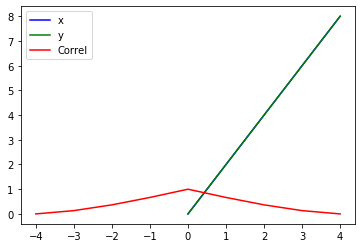

In [102]:
import commpy.filters as com
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np



nZeros = 0

x = np.arange(0,10,2)
y = np.append(np.zeros(nZeros), x) #, np.zeros(0))
z = np.correlate(y, x, 'full')
print('z len', z.size, ' z ', z )
corrLen = 2 * np.max([x.size, y.size]) - 1
print('corrLen', corrLen)
index = np.arange(-np.max([x.size, y.size])+1, np.max([x.size, y.size]), 1)
indexAl = index[-z.size:]
print('index', indexAl, 'lag', indexAl[z.argmax()])
plt.plot(x, 'blue', label='x')
plt.plot(y, 'green', label='y')
plt.plot(indexAl, z/z.max(), 'red', label='Correl')
plt.legend()


signalInChop =  47
signalLen =  47
signalInChop =  47  signalRefChop =  47


0

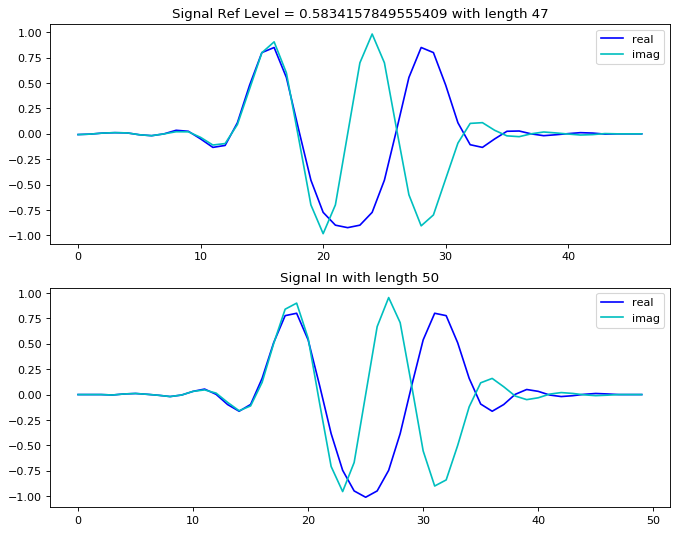

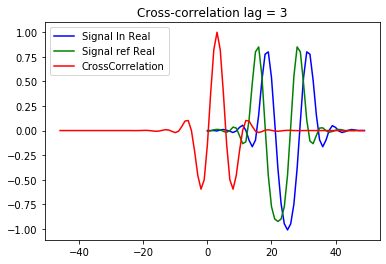

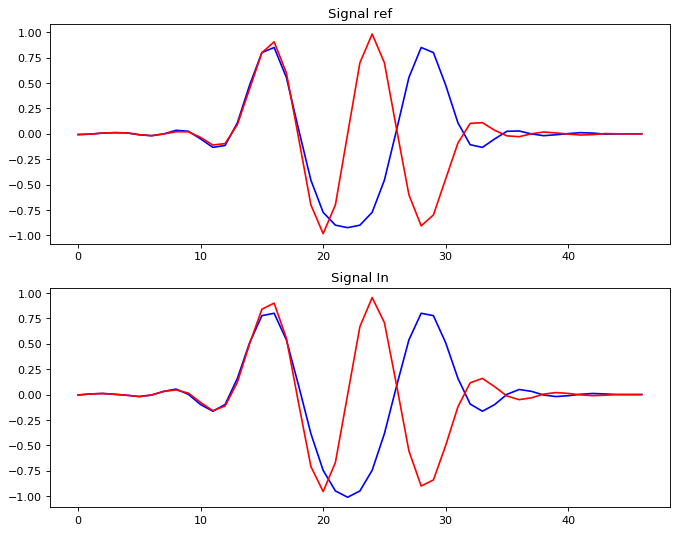

In [124]:
import commpy.filters as com
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np

nZeros = 3
symbAmp = 1/np.sqrt(2)
symbols = np.array([symbAmp +1j*symbAmp, -symbAmp -1j*symbAmp, -symbAmp + 1j*symbAmp, symbAmp -1j*symbAmp])
pulseShapper = np.array([-0.00583243, 0.00857444, 0.0150285, 0.00364796, -0.01586493,
                       -0.01909873, 0.00848826, 0.0484814, 0.05471622, -0.00748792,
                       -0.11553457, -0.18006326, -0.09317284, 0.19053998, 0.59911012,
                        0.96339776, 1.10929582, 0.96339776, 0.59911012, 0.19053998,
                       -0.09317284, -0.18006326, -0.11553457, -0.00748792, 0.05471622,
                        0.0484814, 0.00848826, -0.01909873, -0.01586493, 0.00364796,
                        0.0150285, 0.00857444])

fs = 4e6
symbolRate = 1e6
osr = int(fs/symbolRate)

symbolUp = np.zeros(symbols.size * osr) + 1j * np.zeros(symbols.size * osr)
symbolUp[0::osr]=symbols

signal = np.convolve(symbolUp, pulseShapper)
signal = np.append(np.zeros(nZeros), signal) #, np.zeros(0))

evmMeter(signal, symbols ,fs , 0)


In [115]:
N = 20
x = np.random.randint(0,3,N)
lag = 1
y = x[lag:]
print(x)
print(y)

[1 0 1 0 2 0 1 0 2 2 1 0 0 2 0 0 1 1 2 0]
[0 1 0 2 0 1 0 2 2 1 0 0 2 0 0 1 1 2 0]
